In [ ]:
# Parameters
project_folder = "c:\\\\Users\\\\Sara Bonati\\\\Desktop\\\\MPI work\\\\Machines\\\\Reward_network_task"
solution_columns = ["network_id", "strategy", "step", "source_node", "current_node", "reward", "total_reward"]


# Rule

* in general always take the edge with the larger payoff
* however: take the first large loss (only the first)

In [10]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
import os
import glob
import json
import logging
sns.set_theme()

from environment_sara import Reward_Network

In [13]:
project_folder= 'c:\\Users\\Sara Bonati\\Desktop\\MPI work\\Machines\\Reward_network_task'
solution_columns= ['network_id','strategy','step','source_node','current_node','reward','total_reward']

In [14]:
# directory management
code_dir = os.path.join(project_folder,'reward-network-iii-algorithm')
data_dir = os.path.join(project_folder,'data','dev')

### define agent class

In [16]:
class Rule_Agent:

    def __init__(self,strategy,networks_file):

        # assert tests
        assert strategy in ['highest_payoff','take_first_loss'], f'Strategy name must be one of {["highest_payoff","take_first_loss"]}, got {strategy}'
        assert os.path.exists(networks_file), f'The data file at {networks_file} does not exist'
        
        self.strategy =  strategy
        if self.strategy == 'take_first_loss':
            self.loss_counter = 0
        
        self.networks_file = networks_file
        self.solution = []
        self.solution_filename = os.path.join(data_dir,f'Solution_log_{self.strategy}.csv')
        self.colors = {'highest_payoff':'skyblue','take_first_loss':'orangered'}

    
    def select_action(self):
        """
        This method finds possible actions from the current node and
        selects one based on current strategy
        """
        
        self.possible_actions = [a for a in self.environment.action_space if a['sourceId']==self.environment.current_node]
        self.possible_actions_rewards = np.asarray([a['reward'] for a in self.environment.action_space if a['sourceId']==self.environment.current_node])
        
        # take first loss -> select among possible actions the one that gives best reward BUT make sure to take a first big loss
        if self.strategy == 'take_first_loss' and self.loss_counter<1 and -100 in self.possible_actions_rewards:
            self.loss_counter +=1
            return self.possible_actions[np.argwhere(self.possible_actions_rewards==-100)[0][0]]
            
        else:
            # highest payoff -> select among possible actions the one that gives best reward
            #print(f'select action at index {np.argmax(self.possible_actions_rewards)+1}')
            #print('\n')
            return self.possible_actions[np.argmax(self.possible_actions_rewards)]

    def solve(self):
        """ 
        the agent solves the task, with different constraints depending on the strategy.
        Returns solved reward network in tabular form
        """
        with open(self.networks_file) as json_file:
            self.envs = json.load(json_file)
        
        # loop over all reward networks in data file
        for e in range(len(self.envs)):
            
            self.environment = Reward_Network(self.envs[e])
            self.environment.reset()
            
            while self.environment.is_done==False:
                s = []
                a = self.select_action()
                obs = self.environment.step(a)
                
                s.append(self.environment.id)
                s.append(self.strategy)
                s.append(obs['n_steps'])
                s.append(obs['source_node'])
                s.append(obs['current_node'])
                s.append(obs['reward'])
                s.append(obs['total_reward'])
                self.solution.append(s)

        self.solution_df = pd.DataFrame(self.solution, columns = solution_columns)
        self.solution_df.to_csv(self.solution_filename,sep='\t')

    def inspect_solutions(self):
        g = sns.displot(data=self.df[self.df['step']==8], x="total_reward", kde=True, color=self.colors[self.strategy])
        g.set(xlim=(-300,300),xlabel='Final reward',ylabel='Count')
        plt.show()

## Solve networks + compare strategies' results

Ttest_relResult(statistic=-0.9999999999999998, pvalue=0.3175526601764128)


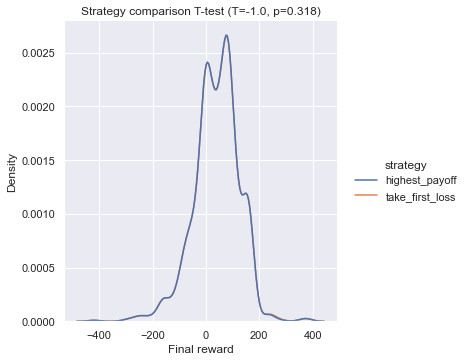

In [18]:
A = Rule_Agent('highest_payoff',os.path.join(data_dir,'train.json'))
A.solve()
B = Rule_Agent('take_first_loss',os.path.join(data_dir,'train.json'))
B.solve()

if os.path.exists(A.solution_filename) and os.path.exists(B.solution_filename):
    # load solution data 
    strategy_A = pd.read_csv(A.solution_filename,sep='\t')
    strategy_A = strategy_A[strategy_A['step']==8]
    strategy_B = pd.read_csv(B.solution_filename,sep='\t')
    strategy_B = strategy_B[strategy_B['step']==8]
    
    # perform t-test
    strategy_data = pd.concat([strategy_A,strategy_B],ignore_index=True)
    result = stats.ttest_rel(strategy_data[strategy_data['strategy']=='highest_payoff']['total_reward'],
                             strategy_data[strategy_data['strategy']=='take_first_loss']['total_reward'])

    #display results
    print(result)

    g=sns.displot(data=strategy_data, x="total_reward", hue="strategy", kind="kde")
    g.set(xlabel='Final reward',ylabel='Density',title=f'Strategy comparison T-test (T={round(result.statistic,3)}, p={round(result.pvalue,3)})')

